In [4]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
# Transformaciones: redimensionar, normalizar, convertir a tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ajusta tamaño al que usarás en la red
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(
    root='../002_cancer/train', transform=transform)
test_data = datasets.ImageFolder(
    root='../002_cancer/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Clases:", train_data.classes)

Clases: ['Benign', 'Malignant']


In [6]:
import os, math, numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# rutas (según tu estructura)
# lo que tenías (mal): BASE_DIR = os.path.join("002cancer")
BASE_DIR = os.path.join("..", "002_cancer")  # desde /notebooks sube a ../002_cancer
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# parámetros que me pediste
CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
EPOCHS  = 15
TEST_MAX_SAMPLES = 2000
SEED    = 42

# dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:",DEVICE)
torch.manual_seed(SEED)
np.random.seed(SEED)

Usando dispositivo: cuda


Epoch 1/15 | Train Loss: 0.4592 | Val Loss: 0.5544 | Val Acc: 0.7690
Epoch 2/15 | Train Loss: 0.4082 | Val Loss: 0.3871 | Val Acc: 0.8250
Epoch 3/15 | Train Loss: 0.3610 | Val Loss: 0.3581 | Val Acc: 0.8430
Epoch 4/15 | Train Loss: 0.3438 | Val Loss: 0.3625 | Val Acc: 0.8320
Epoch 5/15 | Train Loss: 0.3303 | Val Loss: 0.3589 | Val Acc: 0.8335
Epoch 6/15 | Train Loss: 0.3158 | Val Loss: 0.3044 | Val Acc: 0.8720
Epoch 7/15 | Train Loss: 0.3082 | Val Loss: 0.3089 | Val Acc: 0.8600
Epoch 8/15 | Train Loss: 0.3021 | Val Loss: 0.3065 | Val Acc: 0.8745
Epoch 9/15 | Train Loss: 0.2918 | Val Loss: 0.2682 | Val Acc: 0.8920
Epoch 10/15 | Train Loss: 0.2905 | Val Loss: 0.3106 | Val Acc: 0.8640
Epoch 11/15 | Train Loss: 0.2859 | Val Loss: 0.3323 | Val Acc: 0.8295
Epoch 12/15 | Train Loss: 0.2830 | Val Loss: 0.2511 | Val Acc: 0.9070
Epoch 13/15 | Train Loss: 0.2782 | Val Loss: 0.2615 | Val Acc: 0.9150
Epoch 14/15 | Train Loss: 0.2743 | Val Loss: 0.3101 | Val Acc: 0.8685
Epoch 15/15 | Train Loss: 0.2

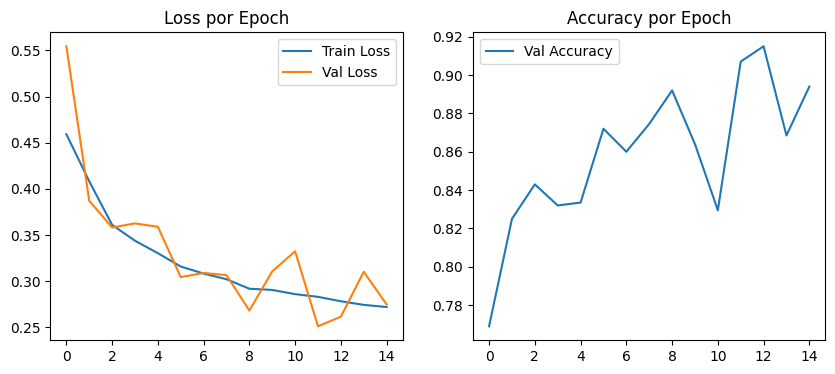

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

learning_rate = 0.001

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

class CompactCNN(nn.Module):
    """
    CNN pequeña con bloques Conv-BN-ReLU, pooling progresivo y
    AdaptiveAvgPool2d(1) para ser robusta al tamaño de entrada.
    Salida: logits de tamaño (N, CLASSES).
    """
    def __init__(self, in_ch=INPUT_CH, num_classes=CLASSES):
        super().__init__()
        # Etapa 1: 3->32
        self.stage1 = nn.Sequential(
            ConvBNReLU(in_ch, 32),
            ConvBNReLU(32, 32),
            nn.MaxPool2d(2),          # /2
            nn.Dropout(0.10),
        )
        # Etapa 2: 32->64
        self.stage2 = nn.Sequential(
            ConvBNReLU(32, 64),
            ConvBNReLU(64, 64),
            nn.MaxPool2d(2),          # /4 acumulado
            nn.Dropout(0.15),
        )
        # Etapa 3: 64->128
        self.stage3 = nn.Sequential(
            ConvBNReLU(64, 128),
            ConvBNReLU(128, 128),
            nn.MaxPool2d(2),          # /8 acumulado
            nn.Dropout(0.20),
        )
        # Etapa 4: 128->128 (un poco más de capacidad)
        self.stage4 = nn.Sequential(
            ConvBNReLU(128, 128),
            nn.MaxPool2d(2),          # /16 acumulado
            nn.Dropout(0.25),
        )

        # Pooling a 1x1 -> vector de 128 dim sin importar HxW de entrada
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Clasificador
        self.classifier = nn.Sequential(
            nn.Flatten(),             # -> (N, 128)
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.40),
            nn.Linear(128, num_classes)  # logits
        )

        self._init_weights()


    def _init_weights(self):
        # Kaiming/He init para conv y fan_out para lineales
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x  # (N, CLASSES)

# --- Modelo, pérdida y optimizador ---
model = CompactCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento ---
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# --- Guardar métricas ---
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'model_state': model.state_dict()
}, 'training_metrics_gpu.pth')  # cambiado a gpu

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()

In [5]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

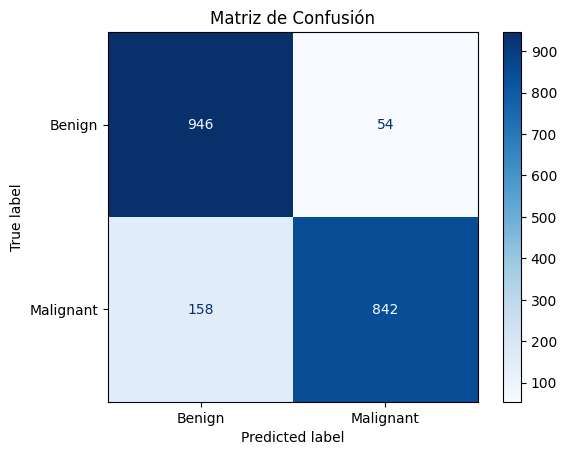

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Usando dispositivo: cuda
Epoch 1/15 | Train Loss: 0.4794 | Val Loss: 0.5166 | Val Acc: 0.7305
Epoch 2/15 | Train Loss: 0.4182 | Val Loss: 0.3994 | Val Acc: 0.8295
Epoch 3/15 | Train Loss: 0.3840 | Val Loss: 0.4334 | Val Acc: 0.8055
Epoch 4/15 | Train Loss: 0.3549 | Val Loss: 0.3289 | Val Acc: 0.8780
Epoch 5/15 | Train Loss: 0.3291 | Val Loss: 0.3828 | Val Acc: 0.8365
Epoch 6/15 | Train Loss: 0.3189 | Val Loss: 0.3268 | Val Acc: 0.8715
Epoch 7/15 | Train Loss: 0.3072 | Val Loss: 0.3072 | Val Acc: 0.8715
Epoch 8/15 | Train Loss: 0.2953 | Val Loss: 0.3310 | Val Acc: 0.8450
Epoch 9/15 | Train Loss: 0.2900 | Val Loss: 0.2896 | Val Acc: 0.8835
Epoch 10/15 | Train Loss: 0.2834 | Val Loss: 0.2803 | Val Acc: 0.9000
Epoch 11/15 | Train Loss: 0.2798 | Val Loss: 0.2727 | Val Acc: 0.8935
Epoch 12/15 | Train Loss: 0.2729 | Val Loss: 0.3171 | Val Acc: 0.8560
Epoch 13/15 | Train Loss: 0.2643 | Val Loss: 0.2636 | Val Acc: 0.9045
Epoch 14/15 | Train Loss: 0.2645 | Val Loss: 0.2467 | Val Acc: 0.9205
Epoc

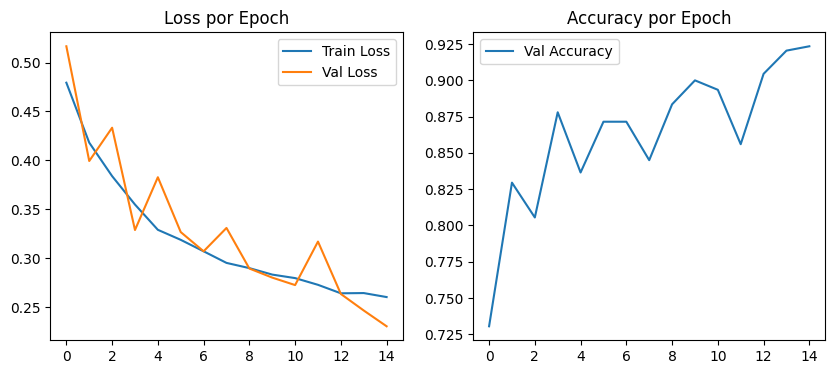

In [7]:
import cv2
import matplotlib.pyplot as plt

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

num_epochs = 15
learning_rate = 0.001

# --- Transformación con heatmap ---
def add_heatmap_channel(img):
    """
    img: tensor 3x224x224 (RGB)
    devuelve: tensor 4x224x224 (RGB + heatmap)
    """
    img_np = img.permute(1, 2, 0).numpy()  # HxWxC
    gray = cv2.cvtColor((img_np*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    heatmap = cv2.GaussianBlur(gray, (15, 15), 0)  # suaviza
    heatmap = heatmap / 255.0  # normaliza
    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0)  # 1xHxW
    return torch.cat([img, heatmap_tensor], dim=0)  # 4xHxW

# --- CNN ligera que acepta 4 canales ---
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)   # 224->112
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)  # 112->56
        )
        self.stage3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 56->28
        )
        self.stage4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()                  # 28->28
        )

        # 👇 solo un global pooling al final
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, len(train_data.classes))
        )

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.gap(x)               # -> (N,128,1,1)
        x = torch.flatten(x, 1)       # -> (N,128)
        return self.classifier(x)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento con heatmap ---
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # agregar canal de heatmap
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images, labels = images.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.stack([add_heatmap_channel(img) for img in images])
            images = images.float()  # ✅ importante
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# --- Guardar métricas ---
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'model_state': model.state_dict()
}, 'training_metrics_gpu_heatmap.pth')

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()

In [9]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # agregar canal de heatmap para cada imagen
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images, labels = images.to(DEVICE).float(), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

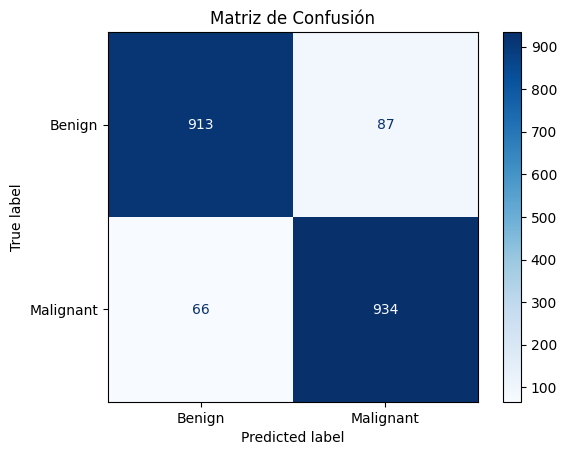

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Usando dispositivo: cuda
Epoch 1/15 | Train Loss: 0.4687 | Val Loss: 0.4863 | Val Acc: 0.7910
Epoch 2/15 | Train Loss: 0.4409 | Val Loss: 0.5025 | Val Acc: 0.8015
Epoch 3/15 | Train Loss: 0.3973 | Val Loss: 0.4195 | Val Acc: 0.8305
Epoch 4/15 | Train Loss: 0.3699 | Val Loss: 0.3329 | Val Acc: 0.8635
Epoch 5/15 | Train Loss: 0.3449 | Val Loss: 0.3651 | Val Acc: 0.8545
Epoch 6/15 | Train Loss: 0.3361 | Val Loss: 0.3381 | Val Acc: 0.8605
Epoch 7/15 | Train Loss: 0.3368 | Val Loss: 0.3636 | Val Acc: 0.8345
Epoch 8/15 | Train Loss: 0.3238 | Val Loss: 0.3354 | Val Acc: 0.8610
Epoch 9/15 | Train Loss: 0.3188 | Val Loss: 0.3109 | Val Acc: 0.8735
Epoch 10/15 | Train Loss: 0.3072 | Val Loss: 0.3629 | Val Acc: 0.8480
Epoch 11/15 | Train Loss: 0.3136 | Val Loss: 0.3551 | Val Acc: 0.8400
Epoch 12/15 | Train Loss: 0.3042 | Val Loss: 0.3142 | Val Acc: 0.8745
Epoch 13/15 | Train Loss: 0.3035 | Val Loss: 0.2939 | Val Acc: 0.8830
Epoch 14/15 | Train Loss: 0.3046 | Val Loss: 0.3275 | Val Acc: 0.8600
Epoc

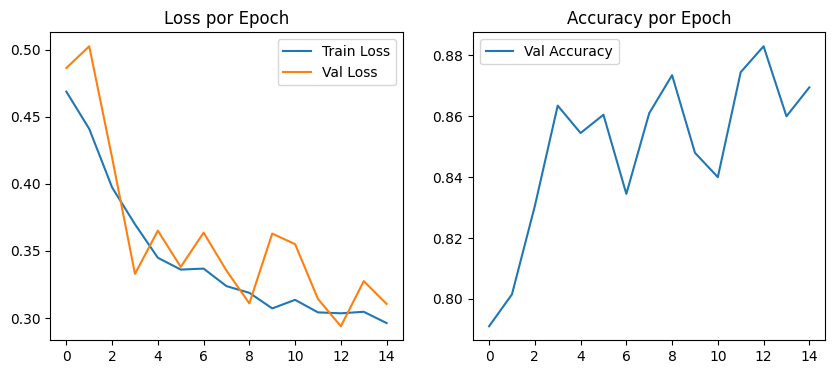

In [7]:
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

num_epochs = 15
learning_rate = 0.001

MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def add_heatmap_channel(img):
    img_vis = (img*STD.to(img.device) + MEAN.to(img.device)).clamp(0,1)
    img_np = img_vis.permute(1,2,0).cpu().numpy()
    gray = cv2.cvtColor((img_np*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    heatmap = cv2.GaussianBlur(gray, (15, 15), 0).astype('float32')/255.0
    heatmap_tensor = torch.from_numpy(heatmap).to(img.device).unsqueeze(0)
    return torch.cat([img, heatmap_tensor], dim=0)

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

class CNN4Stage(nn.Module):
    def __init__(self, in_ch=4, num_classes=2):
        super().__init__()

        # Stage 1: 4 -> 32   (224 -> 112)
        self.stage1 = nn.Sequential(
            ConvBNReLU(in_ch, 32),
            ConvBNReLU(32, 32),
            nn.MaxPool2d(2)
        )

        # Stage 2: 32 -> 64  (112 -> 56)
        self.stage2 = nn.Sequential(
            ConvBNReLU(32, 64),
            ConvBNReLU(64, 64),
            nn.MaxPool2d(2)
        )

        # Stage 3: 64 -> 128 (56 -> 28)
        self.stage3 = nn.Sequential(
            ConvBNReLU(64, 128),
            ConvBNReLU(128, 128),
            nn.MaxPool2d(2)
        )

        # Stage 4: 128 -> 128 (28 -> 28)
        self.stage4 = nn.Sequential(
            ConvBNReLU(128, 128),
            # puedes añadir otra ConvBNReLU si necesitas más capacidad
        )

        # Global Average Pool → vector 128
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Clasificador
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stage1(x)   # (N, 32, 112, 112)
        x = self.stage2(x)   # (N, 64, 56, 56)
        x = self.stage3(x)   # (N, 128, 28, 28)
        x = self.stage4(x)   # (N, 128, 28, 28)
        x = self.gap(x)      # (N, 128, 1, 1)
        x = torch.flatten(x, 1)  # (N, 128)
        return self.classifier(x)

model = CNN4Stage().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento con heatmap ---
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # agregar canal de heatmap
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images, labels = images.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.stack([add_heatmap_channel(img) for img in images])
            images = images.float()  # ✅ importante
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# --- Guardar métricas ---
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'model_state': model.state_dict()
}, 'training_metrics_gpu_heatmap.pth')

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()

In [8]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # agregar canal de heatmap para cada imagen
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images, labels = images.to(DEVICE).float(), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

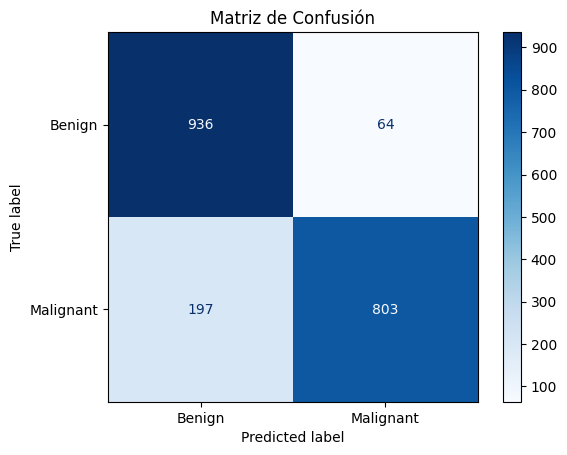

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Área de la lesión: 46155.0 píxeles
Índice de simetría (0-1): 0.982


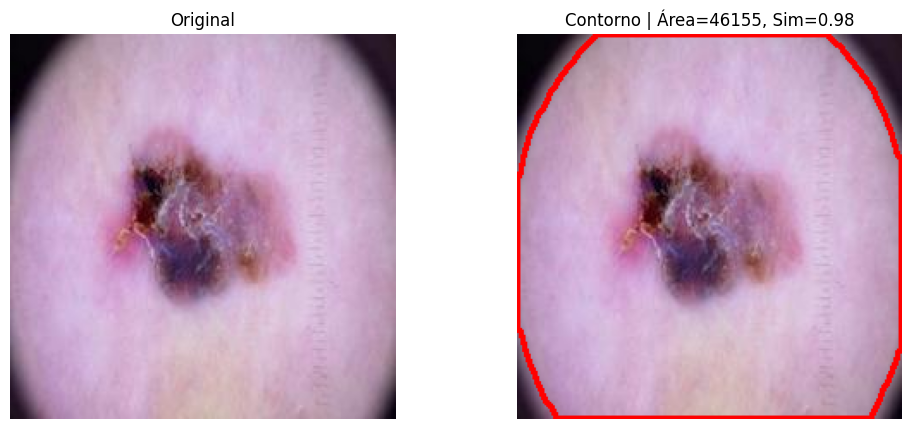

In [10]:
import random, cv2
import numpy as np
import matplotlib.pyplot as plt

# Elegir una imagen al azar del dataset de test
idx = random.randint(0, len(test_data)-1)
img_path, label = test_data.samples[idx]

# Cargar en OpenCV
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Preprocesado: suavizado y umbral
blur = cv2.GaussianBlur(gray, (5,5), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Encontrar contornos
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) == 0:
    print("No se encontró contorno")
else:
    # Elegir el mayor contorno (área máxima)
    c = max(contours, key=cv2.contourArea)

    # Calcular área (en píxeles)
    area = cv2.contourArea(c)

    # Crear máscara binaria de la lesión
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [c], -1, 255, -1)

    # Calcular simetría horizontal:
    # compara máscara con su flip horizontal
    mask_flip = cv2.flip(mask, 1)
    intersection = np.logical_and(mask>0, mask_flip>0).sum()
    union = np.logical_or(mask>0, mask_flip>0).sum()
    symmetry_index = intersection/union if union>0 else 0

    print(f"Área de la lesión: {area:.1f} píxeles")
    print(f"Índice de simetría (0-1): {symmetry_index:.3f}")

    # Mostrar imagen con contorno
    img_contour = img_rgb.copy()
    cv2.drawContours(img_contour, [c], -1, (255,0,0), 2)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(img_contour)
    plt.title(f"Contorno | Área={area:.0f}, Sim={symmetry_index:.2f}")
    plt.axis("off")
    plt.show()

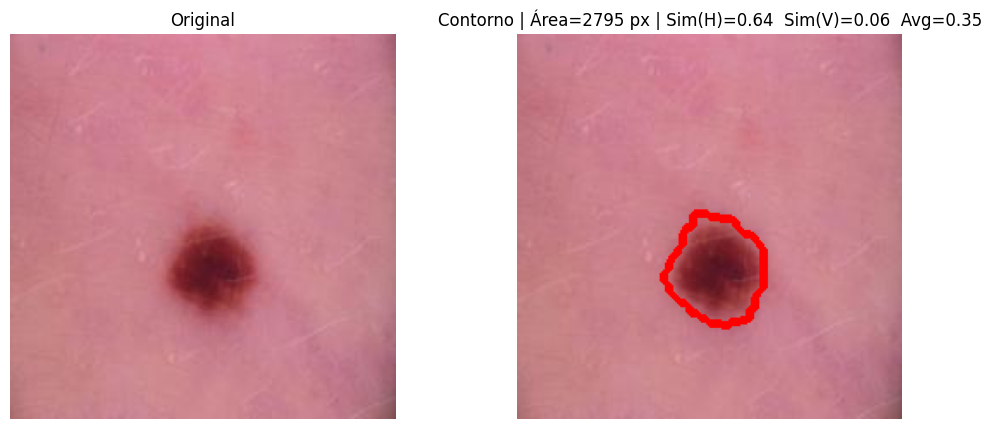

Área (px): 2795
Simetría horizontal: 0.642 | vertical: 0.061 | media: 0.351


In [19]:
import random, cv2, numpy as np, matplotlib.pyplot as plt
from skimage import measure

def mask_largest_component_not_touching_border(mask):
    lab = measure.label(mask, connectivity=2)
    H, W = mask.shape
    best = None
    for i in range(1, lab.max()+1):
        comp = (lab == i)
        # descarta si toca bordes de la imagen
        if comp[0,:].any() or comp[-1,:].any() or comp[:,0].any() or comp[:,-1].any():
            continue
        area = int(comp.sum())
        if area == 0: 
            continue
        ys, xs = np.nonzero(comp)
        cy, cx = ys.mean(), xs.mean()
        d2 = (cy - H/2)**2 + (cx - W/2)**2
        cand = (area, -d2, comp)
        if best is None or cand > best:
            best = cand
    return (best[2].astype(np.uint8) if best else np.zeros_like(mask, np.uint8))

def symmetry(mask, axis='h'):
    mf = np.fliplr(mask) if axis=='h' else np.flipud(mask)
    inter = np.logical_and(mask, mf).sum()
    uni   = np.logical_or(mask, mf).sum()
    return (inter/uni) if uni else 0.0

def detect_dermo_circle(gray):
    # busca un círculo del dermatoscopio; si no lo encuentra, usa radio por defecto
    H, W = gray.shape
    g = cv2.GaussianBlur(gray, (9,9), 0)
    g = cv2.Canny(g, 50, 150)
    circles = cv2.HoughCircles(g, cv2.HOUGH_GRADIENT, dp=1.2, minDist=min(H,W)//2,
                               param1=120, param2=30,
                               minRadius=int(0.35*min(H,W)//2),
                               maxRadius=int(0.95*min(H,W)//2))
    if circles is not None:
        x,y,r = np.uint16(np.around(circles[0][0]))
        return int(x), int(y), int(r*0.92)  # reduce un poco para no tocar el borde
    # fallback: círculo centrado
    cx, cy = W//2, H//2
    r = int(0.45*min(H,W))
    return cx, cy, r

def segment_lesion(img_rgb, k=3):
    H, W = img_rgb.shape[:2]
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # 1) ROI circular del dermatoscopio
    cx, cy, r = detect_dermo_circle(gray)
    Y, X = np.ogrid[:H, :W]
    roi_circle = ((X-cx)**2 + (Y-cy)**2) <= r**2

    # 2) Lab + KMeans (en ab) dentro del círculo
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L   = lab[:,:,0].astype(np.float32)/255.0
    ab  = lab[:,:,1:].reshape(-1,2).astype(np.float32)

    # Sólo pixeles dentro del círculo
    idxs = np.flatnonzero(roi_circle.ravel())
    ab_roi = ab[idxs]
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    _, labels_roi, centers = cv2.kmeans(ab_roi, k, None, criteria, 3, cv2.KMEANS_PP_CENTERS)
    labels_full = np.full(H*W, -1, np.int32); labels_full[idxs] = labels_roi.ravel()
    labels_full = labels_full.reshape(H, W)

    # Elige clúster más oscuro por L
    meanL = []
    for i in range(k):
        m = L[(labels_full==i) & roi_circle]
        meanL.append(float(m.mean()) if m.size else 1.0)
    lesion_cluster = int(np.argmin(meanL))

    seed_fg = ((labels_full==lesion_cluster) & roi_circle).astype(np.uint8)

    # 3) GrabCut con máscara (seguro-fg = clúster oscuro; bordes = bg seguro)
    gc_mask = np.full((H,W), cv2.GC_PR_BGD, np.uint8)
    gc_mask[seed_fg==1] = cv2.GC_FGD
    # anillo exterior como fondo seguro
    outer = ((X-cx)**2 + (Y-cy)**2) >= (r*0.98)**2
    gc_mask[outer] = cv2.GC_BGD

    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)
    cv2.grabCut(img_rgb, gc_mask, None, bgModel, fgModel, 5, cv2.GC_INIT_WITH_MASK)
    mask = np.where((gc_mask==cv2.GC_FGD) | (gc_mask==cv2.GC_PR_FGD), 1, 0).astype(np.uint8)

    # 4) Morfología y quitar componentes que toquen el borde/ROI
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    # quita fuera del círculo
    mask[~roi_circle] = 0
    # elimina comp. que toquen bordes
    mask = mask_largest_component_not_touching_border(mask)

    return mask

# --------- Ejecutar sobre una imagen aleatoria del test ---------
idx = random.randint(0, len(test_data)-1)
img_path, label = test_data.samples[idx]
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

mask = segment_lesion(img_rgb, k=3)

# Si quedó vacía, avisa
if mask.sum() == 0:
    print("No se pudo segmentar la lesión de forma fiable en esta imagen.")
else:
    area_px = int(mask.sum())
    sim_h = symmetry(mask, 'h')
    sim_v = symmetry(mask, 'v')
    sim_avg = (sim_h + sim_v)/2

    # contorno real
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay = img_rgb.copy()
    cv2.drawContours(overlay, contours, -1, (255,0,0), 3)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(overlay); 
    plt.title(f"Contorno | Área={area_px} px | Sim(H)={sim_h:.2f}  Sim(V)={sim_v:.2f}  Avg={sim_avg:.2f}")
    plt.axis('off')
    plt.show()

    print(f"Área (px): {area_px}")
    print(f"Simetría horizontal: {sim_h:.3f} | vertical: {sim_v:.3f} | media: {sim_avg:.3f}")